# Unstable Linear time-varying system with Proportional Control
**Author: Victor Ardulov**

*Date: April 11, 2018*

## Introduction
In this file we will examine a study combining the other 2 examples:
* [Time-varying Oscillator](./TimeVaryingOscillator.ipynb)
* [Unstable System with Proportional Control](./UnstableLinearSystemWithProportionalControl.ipynb)

This is do demonstrate the power of OnlineDMDc found in [`.control`](../online_dmd/control.py)

In [1]:
import numpy as np
import numpy.random as r

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('poster')
sns.set(font_scale=1.4)

from online_dmd.control import OnlineDMDc

## Generating the data

We define our data as 100 evenly spaced snap shots along $0 \leq t < 10$, such that $\Delta t = 0.1$. Our "true" continuous time model dynamics are given by:
$$
\dot{x} = A(t)x(t)
$$
where
$$
A(t) = \begin{bmatrix}
1 & \omega(t) \\
-\omega(t) & 0.1
\end{bmatrix}
$$
and
$$
\omega(t) = 1 + \epsilon t
$$
where $\epsilon$ is chosen to $0.1$

We assume a known controller $B$:
$$
B = \begin{bmatrix}
1 \\
0
\end{bmatrix}
$$

We then use this to compute our 100 time snap shots and eigen-values below:


In [2]:
T = 10
t_diff = 0.1
iterations = int(T/t_diff) - 1
time_space = np.linspace(0, T, num=iterations+1)

omega = lambda t: 1 + 0.1*t
X = np.zeros((iterations + 1, 2))
X[0, :] = np.array([4, 7])
X_auto = np.zeros((iterations + 1, 2))
X_auto[0, :] = np.array([4, 7])

K_prop = -1
u_t = lambda x: K_prop * x
B = np.array([1, 0])
U = np.zeros((iterations+1, 1))

i = 1
true_eigs = []
As = []
for k in np.linspace(t_diff, T, num=iterations):
    A_t = np.matrix([[t_diff, -omega(k)],[omega(k), .1*t_diff]])
    true_eigs.append(np.imag(np.log(np.linalg.eig(A_t)[0])))
    
    control_input = np.matmul(B, u_t(X[i-1]).T) * t_diff
    U[i, :] = control_input
    autonomous_state = np.matmul(X[i-1, :], A_t)*t_diff + X[i-1, :]
    X[i, :] = autonomous_state + control_input
    X_auto[i, :]= np.matmul(X_auto[i-1, :], A_t)*t_diff + X_auto[i-1, :]
    i += 1

true_eigs = np.vstack(true_eigs)

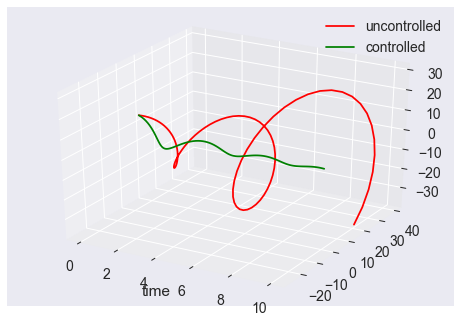

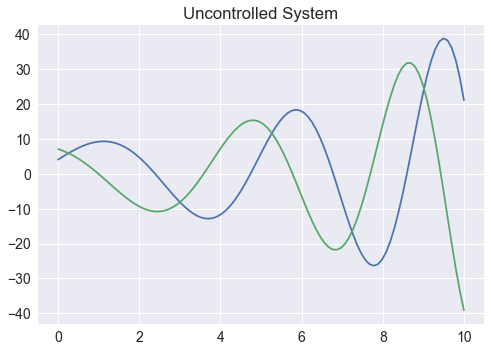

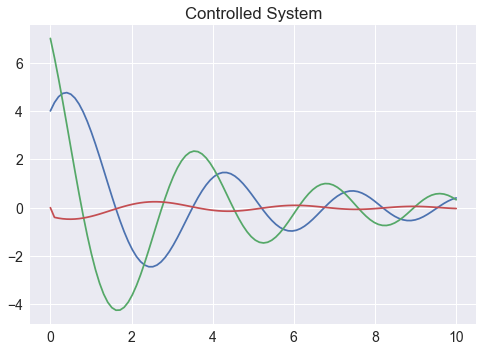

In [3]:
from mpl_toolkits.mplot3d import Axes3D


plt.show()
plt.gca(projection='3d')
plt.plot(time_space, X_auto[:, 0],X_auto[:, 1], 'r', label='uncontrolled')
plt.plot(time_space, X[:, 0],X[:, 1], 'g', label='controlled' )
plt.xlabel('time')
plt.legend()
plt.show()

plt.plot(time_space, X_auto)
plt.title('Uncontrolled System')
plt.show()

plt.plot(time_space, X)
plt.plot(time_space, U)
plt.title('Controlled System')
plt.show()

## Model-fitting

Below we first initialize the fit on the first 10 samples then proceed to update the model one sample point at a time.

We also compute the continuous time eigen values at each time step to compare with those we generate above. The relationship (again from the literature) is that the discrete time DMD eigen values $\mu_{DMD}$ are transposed into continuous time eigen values $\lambda_{DMD}$ by:
$$
\lambda_{DMD} = \frac{\ln(\mu_{DMD})}{\Delta t}
$$

In [4]:
o_dmdc = OnlineDMDc(B=B.reshape(1, 2), track=True)

In [5]:
w = 10
o_dmdc.initial_fit(X[:w, :], U[:w, :], X[1:w+1, :])

In [6]:
o_recorded_eigs = []

for i in range(w+1, X.shape[0]-1):
    o_recorded_eigs.append(np.imag(np.log(np.linalg.eig(o_dmdc.A_k)[0]))/t_diff)
    o_dmdc.update(X[i, :].reshape(1, -1), U[i, :].reshape(1, -1), X[i+1, :].reshape(1, -1))
o_recorded_eigs.append(np.imag(np.log(np.linalg.eig(o_dmdc.A_k)[0]))/t_diff)

In [7]:
o_recorded_eigs = np.vstack(o_recorded_eigs)

## Visualization

Below we reproduce successfully the results presented in the literature, demonstrating the ability of Online DMD methods to accurately capture time-varying dynamics

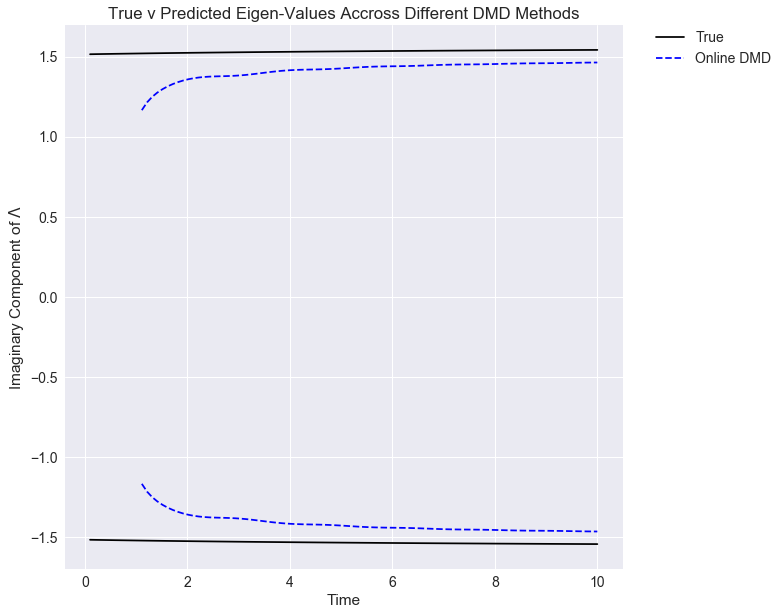

In [8]:
my_fig = plt.figure(figsize=(10, 10))
plt.plot(time_space[1:], true_eigs[:, 0], 'k', label='True' )
plt.plot(time_space[1:], true_eigs[:, 1], 'k')
plt.plot(time_space[w+1:], o_recorded_eigs[:, 0], '--b', label='Online DMD')
plt.plot(time_space[w+1:], o_recorded_eigs[:, 1], '--b')
plt.ylabel(r'Imaginary Component of $\Lambda$')
plt.xlabel('Time')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('True v Predicted Eigen-Values Accross Different DMD Methods')
plt.show()